In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from constant import *
from helpers import *

### 1. Data Loading

In [2]:
DATA_DIR = '../res/recipes/'

In [3]:
# Collect all the recipes for all regions
recipes_lst = []
for filename in os.listdir(DATA_DIR):
  if filename.endswith('.txt'):
    recipes_lst += read_region_file(DATA_DIR+filename)

# Create the dataframe with all the recipes
recipes_df = pd.DataFrame(
  recipes_lst, 
  columns= ['subregion', 'recipe_name', 'ingredients_inferred', 'nb_persons', 'ingredients', 'recipe_body']
)

In [4]:
recipes_df.head()

,subregion,recipe_name,ingredients_inferred,nb_persons,ingredients,recipe_body
0,Alsace,LE KUGELHOPF,with,6,0.5 litre de lait\n500 g farine\n250 g beurre\...,Pour 6 personnes : Mettez dans une terrine 1/2...
1,Alsace,LE SCHWOWCBREDEL,with,6,500 g farine\n500 g sucre\n500 g amandes\n500 ...,Pour 6 personnes: Mélanger farine et beurre. R...
2,Alsace,PARFAIT DE FOIE GRAS STRASBOURGEOISE,with,-,1 kg foie gras oiseau\n1 truffe\n1 dl gelée\n1...,"1 kg de foie gras d’Alsace 1er qualité, dénerv..."
3,Alsace,TRUITES DE LA FECHT COLMARIENNE,with,4,4 truites\n8 écrevisses\n4 œufs\n50 g oignons\...,Pour 4 personnes: Prenez 4 belles truites du t...
4,Alsace,LES SCHANKELAS,with,-,375 g sucre\n250 g amandes\n200 g beurre\n250 ...,Ecraser le beurre avec la farine et bien mêler...


### 2. Data Processing

In [5]:
# Create a column for the region
recipes_df['region'] = recipes_df['subregion'].apply(
  lambda subregion: [region for region, subregions in Region2SubRegion.items() if subregion in subregions][0]
)

In [6]:
# Add the list of ingredients in tuple form for each recipe
recipes_df['ingredients_tuple'] = recipes_df.apply(process_ingredients_from_recipe, axis=1)

In [7]:
recipes_ingredients_list = []
recipes_ingredients_category = []

for idx, recipe in recipes_df.iterrows():
  ingredients_list = []
  ingredients_category = []

  for ing_tuple in recipe['ingredients_tuple']:
    ingredients_list.append(ing_tuple[2])
    ingredients_category.append(ing_tuple[3])
  
  recipes_ingredients_list.append(ingredients_list)
  recipes_ingredients_category.append(ingredients_category)

# Column containing the ingredients content for each recipe
recipes_df['ingredients_list'] = recipes_ingredients_list

# Column containing the ingredients category for each recipe
recipes_df['ingredients_category'] = recipes_ingredients_category


In [8]:
recipes_df = recipes_df[[
  'region', 'subregion', 'recipe_name', 'nb_persons', 'ingredients', 'ingredients_tuple', 
  'ingredients_list', 'ingredients_category', 'recipe_body', 'ingredients_inferred'
]]

In [9]:
recipes_df.head()

,region,subregion,recipe_name,nb_persons,ingredients,ingredients_tuple,ingredients_list,ingredients_category,recipe_body,ingredients_inferred
0,"Bourgogne, Champagne, Bresse, Franche-Comté, A...",Alsace,LE KUGELHOPF,6,0.5 litre de lait\n500 g farine\n250 g beurre\...,"{(1, pincée, sel, Epice), (0.5, litre, lait, P...","[sel, lait, œufs, levure de boulanger, eau-de-...","[Epice, Produit laitier, Œuf, Champignon, -, -...",Pour 6 personnes : Mettez dans une terrine 1/2...,with
1,"Bourgogne, Champagne, Bresse, Franche-Comté, A...",Alsace,LE SCHWOWCBREDEL,6,500 g farine\n500 g sucre\n500 g amandes\n500 ...,"{(500, g, beurre, -), (2, -, œufs, Œuf), (500,...","[beurre, œufs, amandes, cannelle en poudre, ea...","[-, Œuf, Fruit sec, Epice, -, Céréale, -, Fruit]",Pour 6 personnes: Mélanger farine et beurre. R...,with
2,"Bourgogne, Champagne, Bresse, Franche-Comté, A...",Alsace,PARFAIT DE FOIE GRAS STRASBOURGEOISE,-,1 kg foie gras oiseau\n1 truffe\n1 dl gelée\n1...,"{(1, dl, gelée, -), (1, -, truffe, Champignon)...","[gelée, truffe, foie gras oiseau, beurre]","[-, Champignon, Viande, -]","1 kg de foie gras d’Alsace 1er qualité, dénerv...",with
3,"Bourgogne, Champagne, Bresse, Franche-Comté, A...",Alsace,TRUITES DE LA FECHT COLMARIENNE,4,4 truites\n8 écrevisses\n4 œufs\n50 g oignons\...,"{(-, -, laurier, Plante aromatique), (0.5, lit...","[laurier, vin blanc, persil, thym, carottes, t...","[Plante aromatique, Alcool, Plante aromatique,...",Pour 4 personnes: Prenez 4 belles truites du t...,with
4,"Bourgogne, Champagne, Bresse, Franche-Comté, A...",Alsace,LES SCHANKELAS,-,375 g sucre\n250 g amandes\n200 g beurre\n250 ...,"{(250, g, farine, Céréale), (200, g, beurre, -...","[farine, beurre, vanille, citron, sucre, œufs,...","[Céréale, -, -, Fruit, -, Œuf, -, Fruit sec]",Ecraser le beurre avec la farine et bien mêler...,with


### 3. Data Analysis

In [10]:
# Categories used for the analysis
ingredients_categories = list(Categories.keys())
ingredients_categories.append('-')


#### 3.1 Overall Analysis

##### Frequency of ingredients

In [11]:
ing_dic = ingredients_frequency(recipes_df)
ing_dic

{'beurre': 180,
 'sel': 167,
 'poivre': 146,
 'œufs': 101,
 'oignons': 95,
 'farine': 89,
 'persil': 82,
 'ail': 76,
 'vin blanc': 69,
 'bouquet garni': 46,
 'échalotes': 41,
 'carottes': 37,
 'champignons': 37,
 'laurier': 35,
 'lait': 33,
 "huile d'olive": 32,
 'citron': 31,
 'bouillon': 31,
 'sucre': 30,
 'thym': 28,
 'pommes de terre': 27,
 'vinaigre': 26,
 'estragon': 26,
 'huile': 25,
 'échalote': 24,
 'tomates': 24,
 'lard porc': 22,
 'muscade': 19,
 'vin rouge': 18,
 'truffe': 17,
 'crème fraîche': 17,
 'cerfeuil': 17,
 'jambon porc': 16,
 'épices': 15,
 'moutarde': 14,
 'mie de pain': 14,
 'crème': 14,
 'poulet': 13,
 'petits oignons': 13,
 'foie gras oiseau': 12,
 'crème double': 12,
 'céleri': 11,
 'gruyère': 11,
 'poireaux': 11,
 'eau-de-vie': 11,
 'sucre en poudre': 11,
 'écrevisses': 9,
 'pomme de terre': 9,
 'truffes': 9,
 'lardons porc': 9,
 'chapelure': 8,
 'pain': 8,
 'fines herbes': 8,
 'clou de girofle': 8,
 'gros oignons': 8,
 'piment rouge': 8,
 'clous de girofle'

<AxesSubplot:title={'center':'Top 10 most frequently used ingredients'}, xlabel='Ingredient'>

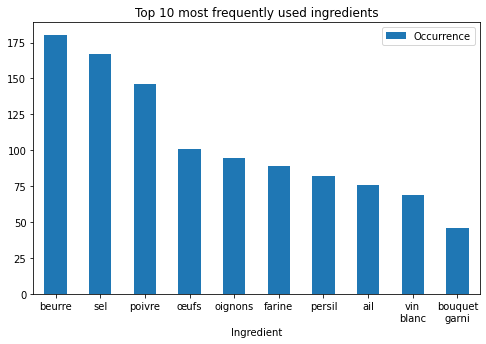

In [12]:
ing_df = pd.DataFrame({
  'Ingredient': [k.replace(' ', '\n') for k in take(10, ing_dic.keys())], 
  'Occurrence': take(10, ing_dic.values())
})
ing_df.plot.bar(x='Ingredient', y='Occurrence', rot=0, figsize=(8, 5), title='Top 10 most frequently used ingredients')

##### Frequency of ingredient categories

In [13]:
cat_dic = categories_frequency(recipes_df)
cat_dic

{'-': 514,
 'Epice': 444,
 'Plante aromatique': 377,
 'Légume': 345,
 'Viande': 322,
 'Céréale': 147,
 'Alcool': 144,
 'Fruit': 120,
 'Œuf': 114,
 'Produit laitier': 110,
 'Champignon': 88,
 'Poisson': 76,
 'Fruit de mer': 34,
 'Légumineuse': 21,
 'Fruit sec': 11}

<AxesSubplot:title={'center':'Distribution of occurrences of categories'}, xlabel='Category'>

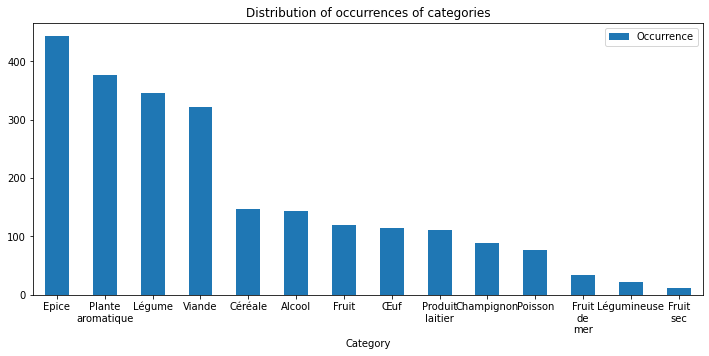

In [17]:
cat_df = pd.DataFrame({
  # Remove the uncategorized ingredients starting by index 1
  'Category': [k.replace(' ', '\n') for k in cat_dic.keys()][1:], 
  'Occurrence': list(cat_dic.values())[1:]
})
cat_df.plot.bar(x='Category', y='Occurrence', rot=0, figsize=(12, 5), title='Distribution of occurrences of categories')

#### 3.2 Analysis per Subregions

##### Frequency of ingredient categories

In [26]:
recipes_per_subregion = recipes_df.groupby('subregion').agg(nb_recipies=('recipe_name','count'))

In [18]:
# Create a frequency matrix (Subregion x Category)
heatmap_subregions_df = pd.DataFrame(0, columns=list(ingredients_categories), index=recipes_df.subregion.unique())

# Go through each recipe
for index, recipe in recipes_df.iterrows():
  # Get the subregion of the recipe
  subregion = heatmap_subregions_df.loc[recipe.subregion]

  # Increase the count of each category present in the recipe for its associated region
  for c in recipe.ingredients_category:
    subregion[c] += 1

In [42]:
# Normalize with the number of recipes per subregion
heatmap_subregions_df = heatmap_subregions_df.apply(lambda col: col / recipes_per_subregion['nb_recipies'], axis=0)

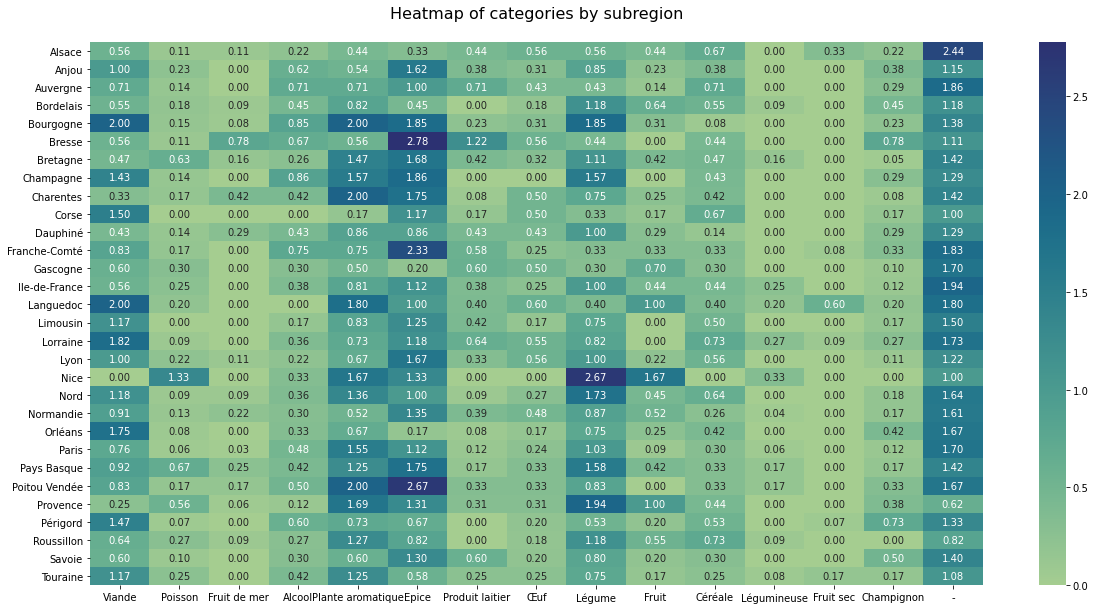

In [44]:
plt.figure(figsize=(20, 10))
plt.title('Heatmap of categories by subregion\n', fontsize=16)
sns.heatmap(heatmap_subregions_df, cmap="crest", annot=True, fmt=".2f")
plt.xticks(rotation=0)
plt.show()

In [45]:
# Compute a matrix of co-occurences (within subregions) of ingredients categories
co_occurences = heatmap_subregions_df.T.dot(heatmap_subregions_df)
np.fill_diagonal(co_occurences.values, 0)

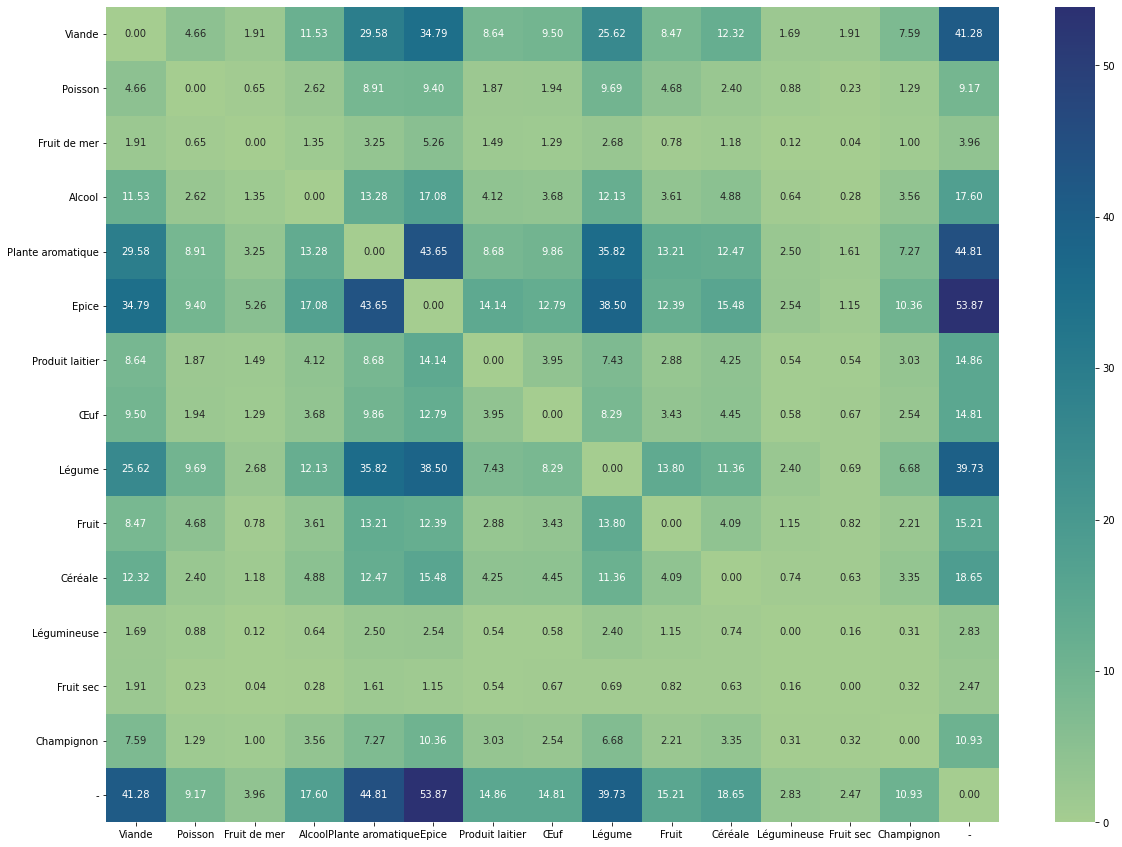

In [47]:
plt.figure(figsize=(20, 15))
sns.heatmap(co_occurences, cmap="crest", annot=True, fmt=".2f")
plt.xticks(rotation=0)
plt.show()

#### 3.3 Analysis per Region

##### Frequency of ingredient categories

In [27]:
recipes_per_region = recipes_df.groupby('region').agg(nb_recipies=('recipe_name','count'))

In [31]:
# Create a frequency matrix (Region x Category)
heatmap_regions_df = pd.DataFrame(0, columns=list(ingredients_categories), index=recipes_df.region.unique())

# Go through each recipe
for index, recipe in recipes_df.iterrows():
  # Get the subregion of the recipe
  region = heatmap_regions_df.loc[recipe.region]

  # Increase the count of each category present in the recipe for its associated region
  for c in recipe.ingredients_category:
    region[c] += 1

In [38]:
# Normalize with the number of recipes per region
heatmap_regions_df = heatmap_regions_df.apply(lambda col: col / recipes_per_region['nb_recipies'], axis=0)

In [39]:
heatmap_regions_df.rename(index={'Bourgogne, Champagne, Bresse, Franche-Comté, Alsace, Lorraine':
              'Bourgogne,\nChampagne,\nBresse,\nFranche-Comté,\nAlsace,\nLorraine'}, inplace=True)
heatmap_regions_df

,Viande,Poisson,Fruit de mer,Alcool,Plante aromatique,Epice,Produit laitier,Œuf,Légume,Fruit,Céréale,Légumineuse,Fruit sec,Champignon,-
"Bourgogne,\nChampagne,\nBresse,\nFranche-Comté,\nAlsace,\nLorraine",1.245902,0.131148,0.147541,0.622951,1.032787,1.737705,0.524590,0.377049,0.934426,0.196721,0.426230,0.049180,0.081967,0.344262,1.639344
Nord & Normandie,1.000000,0.117647,0.176471,0.323529,0.794118,1.235294,0.294118,0.411765,1.147059,0.500000,0.382353,0.029412,0.000000,0.176471,1.617647
"Paris, Ile-de-France, Val de Loire",0.945205,0.136986,0.013699,0.424658,1.191781,0.876712,0.191781,0.232877,0.931507,0.205479,0.342466,0.095890,0.027397,0.178082,1.643836
Pays de l’Ouest,0.620000,0.360000,0.180000,0.420000,1.420000,1.800000,0.320000,0.360000,0.920000,0.280000,0.420000,0.080000,0.000000,0.180000,1.380000
Sud-Est & Méditérannée,0.714286,0.257143,0.057143,0.257143,0.942857,1.257143,0.400000,0.328571,1.100000,0.414286,0.442857,0.014286,0.000000,0.271429,1.200000
Sud-Ouest & Pyrénées,0.968750,0.281250,0.078125,0.390625,0.984375,0.812500,0.156250,0.296875,0.906250,0.515625,0.484375,0.078125,0.062500,0.312500,1.328125


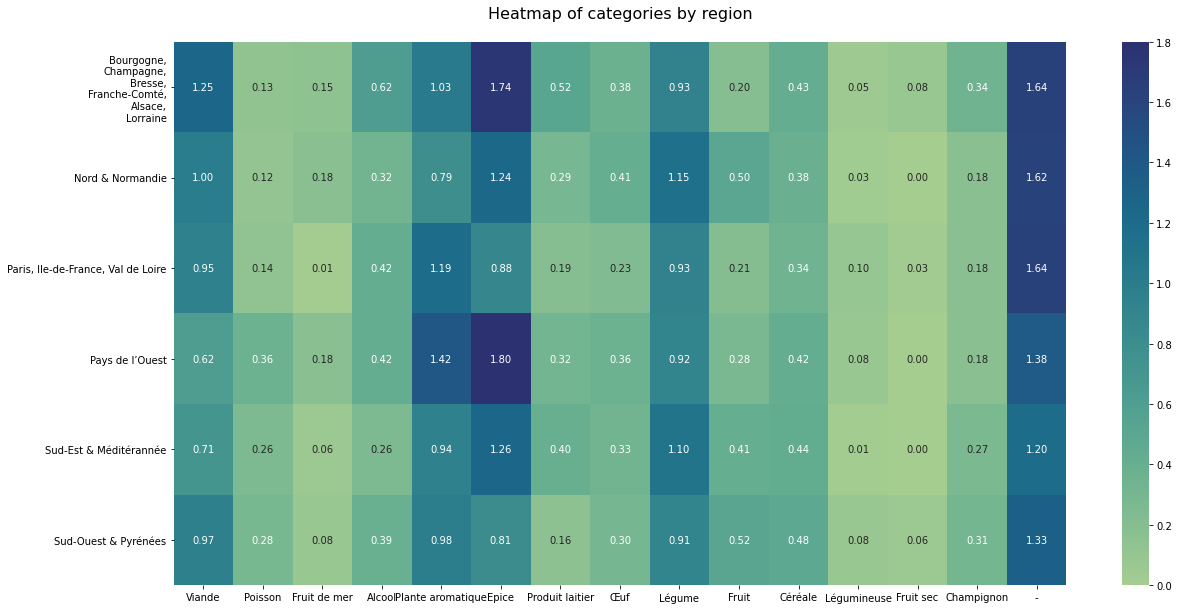

In [41]:
plt.figure(figsize=(20, 10))
plt.title('Heatmap of categories by region\n', fontsize=16)
sns.heatmap(heatmap_regions_df, cmap="crest", annot=True, fmt=".2f")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()